# Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm

# Custom
from config import model_config
from regression import reg

# Stats
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer, FunctionTransformer
)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Global vars
SEED = 123
TEST_SIZE = 0.25
HEATMAP_COLORS = sns.diverging_palette(h_neg=250, h_pos=359, as_cmap=True)
SIGNIFICANCE_CUTOFF = 0.05

# Import/Preprocess Data

In [48]:
with open(Path('../data/prediction_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y')
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')

print(X.shape)

X.head()

(95, 20)


,density_visceral_fat,mass_visceral_fat,mass_subcutaneous_fat,volume_intermuscular_fat,density_intermuscular_fat,volume_bone,density_bone,emphysema_volume_950hu,extrapulmonary_artery_volume,extrapulmonary_vein_volume,artery_vein_ratio,bv5,pb_larger_10,a_diameter,pv_a,heart_volume,airway_ratio,ild_volume,age,gender_cl_Male
PE1_0,-0.804596,-0.969463,0.497278,1.349906,-0.066012,1.477535,-1.765047,0.438930,5.199338,1.999251,-1.002616,0.069569,1.822160,0.991202,1.210445,1.850031,-0.337287,-0.526597,-0.112621,1.0
PE12_0,-0.132313,0.916458,-0.046799,1.242486,-0.804596,1.040478,-0.614999,0.087296,0.840123,0.333656,0.030102,0.738867,0.526128,-0.635812,1.252520,0.160081,0.476079,0.915470,-0.382953,1.0
PE12_1,0.132313,1.400755,0.420188,0.258853,1.070042,1.371373,-0.146385,-0.883951,-0.067041,-0.064891,-0.090059,-1.788431,0.742710,0.033879,-0.144563,0.538562,1.532356,1.538987,-0.382953,1.0
PE14_0,1.412188,-0.616023,-0.014430,-0.973609,1.354934,0.845303,-0.230610,0.919527,-0.291114,0.480681,-0.150563,0.096692,0.103346,-0.177808,0.107054,0.173045,-0.634757,-5.199338,-1.003148,0.0
PE15_0,1.252120,-5.199338,-1.714405,-1.607818,1.252120,-1.002303,0.854752,0.107185,-0.850771,-0.550969,0.291864,0.510249,-0.823013,-1.651436,0.332595,-1.000827,0.098444,-0.090063,-5.199338,0.0


In [49]:
y.head()

,total_clot_burden,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,superior_rs6,medial_basal_rs7,anterior_basal_rs8,...,posterior_basal_rs10,apical_ls1,posterior_ls2,anterior_ls3,superior_ls4,inferior_ls5,superior_ls6,anteromedial_basal_ls7_8,lateral_basal_ls9,posterior_basal_ls10
PE1_0,1.067154,0.935442,1.255586,1.258075,1.285853,1.272841,1.292814,1.515897,0.750988,0.925565,...,0.956399,-5.199338,-5.199338,0.847915,1.427748,-5.199338,-5.199338,0.605601,0.990412,0.808320
PE12_0,-0.180396,-0.230049,0.486956,-5.199338,0.452713,1.196428,1.040493,0.294385,-5.199338,1.252758,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
PE12_1,-0.041386,0.174075,-5.199338,-5.199338,-5.199338,0.608237,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
PE14_0,-0.133834,0.001879,-5.199338,-5.199338,-5.199338,0.571489,-5.199338,-5.199338,-5.199338,1.002920,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.024042,-5.199338,-5.199338,0.703732,-5.199338
PE15_0,-0.474449,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.468258


In [50]:
print(body_features)
print(cardio_features)

['density_visceral_fat', 'mass_visceral_fat', 'mass_subcutaneous_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'volume_bone', 'density_bone']
['emphysema_volume_950hu', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_ratio', 'ild_volume']


# OLS Regression Functions

We loop through each of the numerical target variables (the various clot burden measures for different locations, as well as the total clot burden), and perform a simple single-variable OLS regression. Shown below are the statistically significant results at the 95% confidence level.

In [51]:
def combine_feat_and_controls(features=None, controls=None):
	if isinstance(features, str):
		feat_set = set([features])
	elif isinstance(features, list):
		feat_set = set(features)
	if controls is None:
		control_set = set()
	else:
		control_set = set(controls)
	all_feat = list(feat_set.union(control_set))
	return all_feat

def ols_regression(Xdata, Ydata, targets, features=None, controls=None):
	if controls is not None:
		control_name = '_'.join(controls)
	else:
		control_name = 'None'
	all_target_results = list()
	for target in targets:
		y_temp = Ydata[[target]].copy()
		single_model_results = list()
		for feat in features:
			temp_features = combine_feat_and_controls(feat, controls)
			X_temp = sm.add_constant(Xdata.loc[:, temp_features].copy())
			regression_results = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
			results_df = pd.DataFrame({
				'coef': regression_results.params,
				'pvalue': regression_results.pvalues,
				'nobs': regression_results.nobs,
				'r2_adj': regression_results.rsquared_adj,
			}).stack()
			results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
			results_df.name = (target, feat, control_name)
			single_model_results.append(results_df)
		all_model_results = pd.concat(single_model_results, axis=1).transpose()
		all_model_results.columns = ['_'.join(item) for item in all_model_results.columns.to_list()]
		all_model_results.index.names = ['y_var', 'x_var', 'controls']
		all_target_results.append(all_model_results)
	all_target_results_df = pd.concat(all_target_results, axis=0)
	all_target_results_df = all_target_results_df.sort_index()
	return all_target_results_df

def ols_identify_significant(ols_results, signif_cutoff, out_path, display=False):
	signif_cb_bodycomp = (
		ols_results.loc[ols_results.variable_pvalue <= signif_cutoff, :]
		.sort_values(by='variable_pvalue')
	)
	signif_cb_bodycomp.to_csv(out_path)
	if display:
		return (
			signif_cb_bodycomp
			.style
				.background_gradient(subset='variable_pvalue')
				.format("{:.3f}")
		)
	else:
		return None

def ols_heatmap(ols, out_path, subtitle, figsize=(9, 7)):
	ols = ols.copy()
	ols.index = pd.MultiIndex.from_tuples(zip(ols.index.get_level_values(0), ols.index.get_level_values(1)))
	fig, axs = plt.subplots(figsize=figsize)
	sns.heatmap(
		ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_coef.unstack(level=1),
		annot=ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_pvalue.unstack(level=1), 
		annot_kws={"fontsize":8},
		fmt = '.3f',
		center=0.0,
		cmap=HEATMAP_COLORS,
	)

	for t in axs.texts: 
		t.set_text('p=' + t.get_text())

	axs.set_ylabel('Clot Burden Measure')
	axs.set_xlabel('Body Composition Measure')
	plt.suptitle('Coefficient Heatmap: red=positive coef, blue=negative coef', fontsize=16)
	plt.title(subtitle, fontsize=14)
	plt.tight_layout()
	plt.savefig(out_path)
	plt.show()
	
def r2_adjusted(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

In [52]:
ols_nocontrols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=None
)
ols_nocontrols

const_coef  \
y_var              x_var                     controls               
anterior_basal_rs8 density_bone              None       -2.659394   
                   density_intermuscular_fat None       -2.651197   
                   density_visceral_fat      None       -2.663637   
                   mass_subcutaneous_fat     None       -2.660840   
                   mass_visceral_fat         None       -2.659742   
...                                                           ...   
total_clot_burden  density_visceral_fat      None       -0.120396   
                   mass_subcutaneous_fat     None       -0.118820   
                   mass_visceral_fat         None       -0.119418   
                   volume_bone               None       -0.119526   
                   volume_intermuscular_fat  None       -0.118024   

                                                       const_pvalue  \
y_var              x_var                     controls                 
anterior_basal_rs8 density_bone              None      2.310575e-16   
                   density_intermuscular_fat None      1.129034e-16   
                   density_visceral_fat      None      2.153180e-17   
                   mass_subcutaneous_fat     None      2.748827e-16   
                   mass_visceral_fat         None      1.890044e-16   
...                                                             ...   
total_clot_burden  density_visceral_fat      None      4.313687e-01   
                   mass_subcutaneous_fat     None      4.395731e-01   
                   mass_visceral_fat         None      4.353304e-01   
                   volume_bone               None      4.378509e-01   
                   volume_intermuscular_fat  None      4.378311e-01   

                                                       const_nobs  \
y_var              x_var                     controls               
anterior_basal_rs8 density_bone              None            95.0   
                   density_intermuscular_fat None            95.0   
                   density_visceral_fat      None            95.0   
                   mass_subcutaneous_fat     None            95.0   
                   mass_visceral_fat         None            95.0   
...                                                           ...   
total_clot_burden  density_visceral_fat      None            95.0   
                   mass_subcutaneous_fat     None            95.0   
                   mass_visceral_fat         None            95.0   
                   volume_bone               None            95.0   
                   volume_intermuscular_fat  None            95.0   

                                                       const_r2_adj  \
y_var              x_var                     controls                 
anterior_basal_rs8 density_bone              None         -0.010722   
                   density_intermuscular_fat None          0.029164   
                   density_visceral_fat      None          0.039104   
                   mass_subcutaneous_fat     None         -0.007427   
                   mass_visceral_fat         None         -0.009163   
...                                                             ...   
total_clot_burden  density_visceral_fat      None          0.002829   
                   mass_subcutaneous_fat     None         -0.008199   
                   mass_visceral_fat         None         -0.010502   
                   volume_bone               None         -0.007682   
                   volume_intermuscular_fat  None         -0.008464   

                                                       variable_coef  \
y_var              x_var                     controls                  
anterior_basal_rs8 density_bone              None           0.014525   
                   density_intermuscular_fat None          -0.521351   
                   density_visceral_fat      None          -0.581965   
                   mass_subcutaneous_fat     None  

# Body Composition

## Univariate Regressions

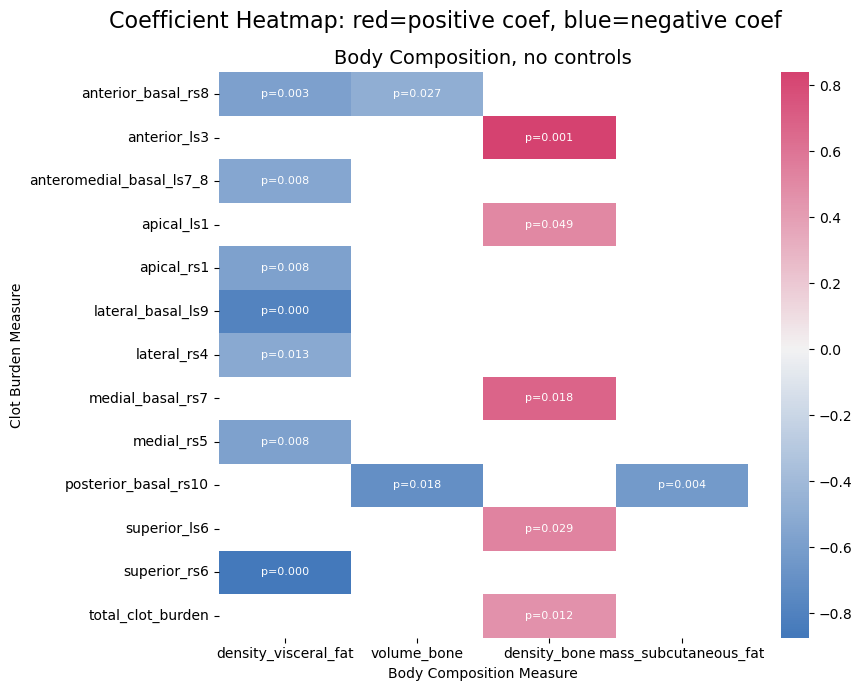

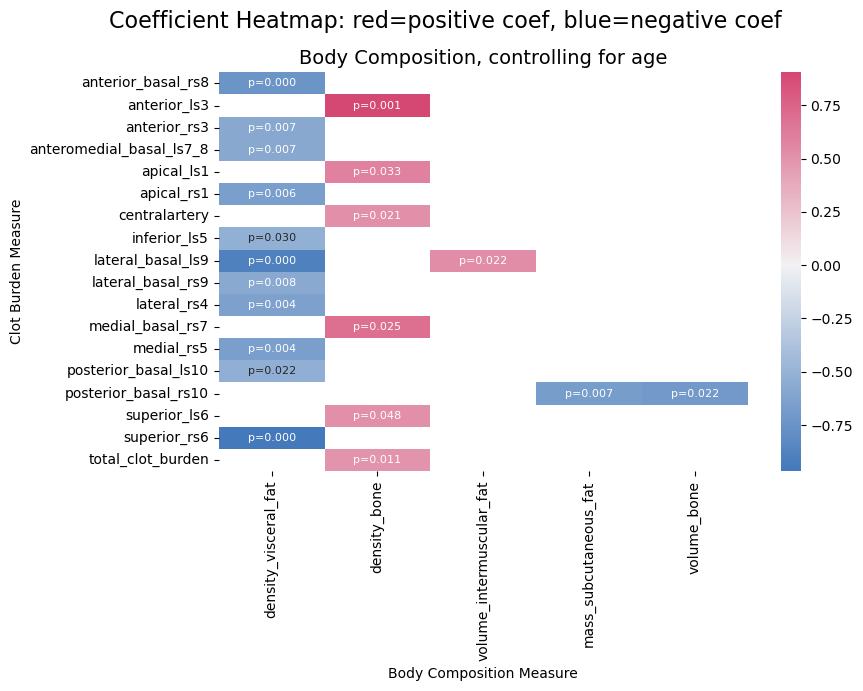

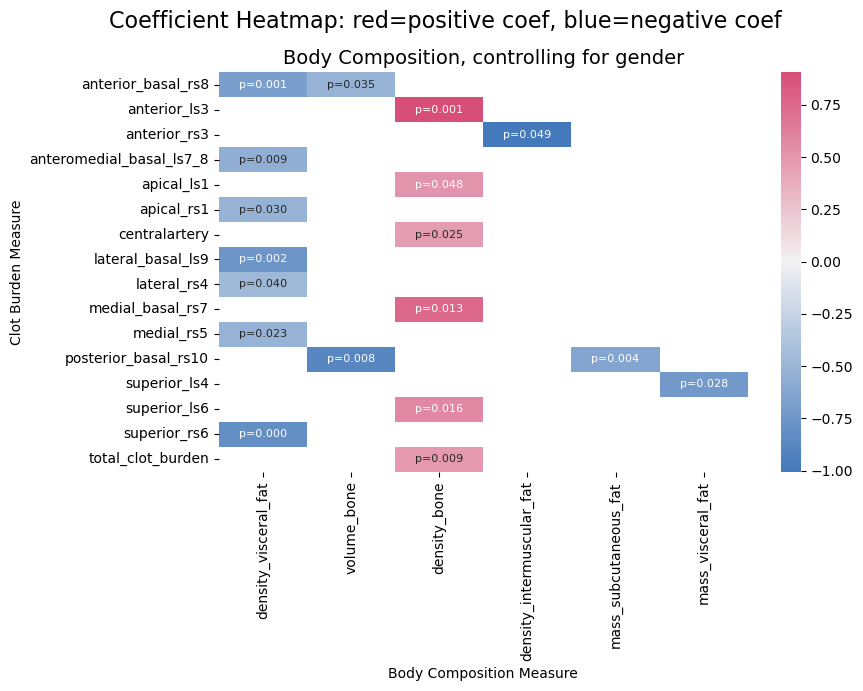

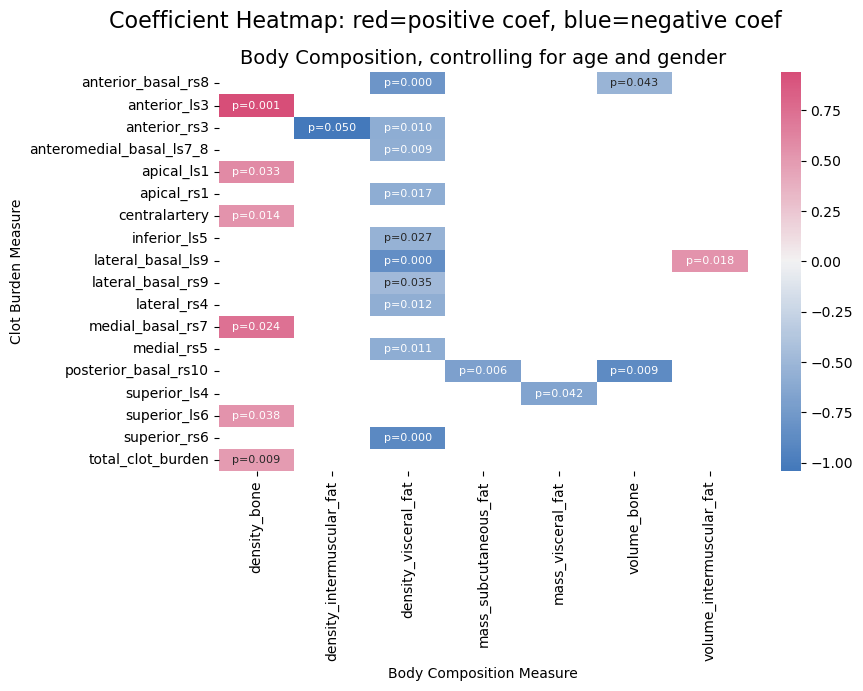

In [53]:
body_regressions_df = pd.DataFrame()

#########################################
# OLS Body, No Controls                 #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=None
)

plot_subtitle = 'Body Composition, no controls'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[None].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)

#########################################
# OLS Body, control for age             #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age']
)
plot_subtitle = 'Body Composition, controlling for age'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[age].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)

#########################################
# OLS Body, control for gender          #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for gender'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[gender_cl_Male].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)

#########################################
# OLS Body, control for age and gender  #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age', 'gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for age and gender'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[age, gender].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)


In [54]:
body_regressions_df.head()

const_coef  \
y_var              x_var                     controls               
anterior_basal_rs8 density_bone              None       -2.659394   
                   density_intermuscular_fat None       -2.651197   
                   density_visceral_fat      None       -2.663637   
                   mass_subcutaneous_fat     None       -2.660840   
                   mass_visceral_fat         None       -2.659742   

                                                       const_pvalue  \
y_var              x_var                     controls                 
anterior_basal_rs8 density_bone              None      2.310575e-16   
                   density_intermuscular_fat None      1.129034e-16   
                   density_visceral_fat      None      2.153180e-17   
                   mass_subcutaneous_fat     None      2.748827e-16   
                   mass_visceral_fat         None      1.890044e-16   

                                                       const_nobs  \
y_var              x_var                     controls               
anterior_basal_rs8 density_bone              None            95.0   
                   density_intermuscular_fat None            95.0   
                   density_visceral_fat      None            95.0   
                   mass_subcutaneous_fat     None            95.0   
                   mass_visceral_fat         None            95.0   

                                                       const_r2_adj  \
y_var              x_var                     controls                 
anterior_basal_rs8 density_bone              None         -0.010722   
                   density_intermuscular_fat None          0.029164   
                   density_visceral_fat      None          0.039104   
                   mass_subcutaneous_fat     None         -0.007427   
                   mass_visceral_fat         None         -0.009163   

                                                       variable_coef  \
y_var              x_var                     controls                  
anterior_basal_rs8 density_bone              None           0.014525   
                   density_intermuscular_fat None          -0.521351   
                   density_visceral_fat      None          -0.581965   
                   mass_subcutaneous_fat     None           0.147374   
                   mass_visceral_fat         None          -0.100320   

                                                       variable_pvalue  \
y_var              x_var                     controls                    
anterior_basal_rs8 density_bone              None             0.960550   
                   density_intermuscular_fat None             0.199596   
                   density_visceral_fat      None             0.003258   
                   mass_subcutaneous_fat     None             0.663681   
                   mass_visceral_fat         None             0.706206   

                                                       variable_nobs  \
y_var              x_var                     controls                  
anterior_basal_rs8 density_bone              None               95.0   
                   density_intermuscular_fat None               95.0   
                   density_visceral_fat      None               95.0   
                   mass_subcutaneous_fat     None               95.0   
                   mass_visceral_fat         None               95.0   

                                                       variable_r2_adj  \
y_var              x_var                     controls                    
anterior_basal_rs8 density_bone              None            -0.010722   
                   density_intermuscular_fat None             0.029164   
                   density_visceral_fat      None             0.039104   
                   mass_subcutaneous_fat     None            -0.007427   
                   mass_visceral_fat         None            -0.009163   

                                           

## Multivariable Regressions

### Feature Selection

#### Recursive Feature Selection

In [55]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[body_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

In [56]:
rfecv_regressions = pd.DataFrame()

for target in y.columns:
	x_vars = rfecv_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip(
            ['rfecv' for _ in range(res.shape[0])],
            [target for _ in range(res.shape[0])], 
            res.index)
            ),
		names=('feature_selection_method', 'y', 'X')
	)
	rfecv_regressions = pd.concat((rfecv_regressions, res), axis=0)

rfecv_regressions.head()

coef  \
feature_selection_method y                 X                                    
rfecv                    total_clot_burden const                    -0.115706   
                                           density_bone              0.459730   
                         centralartery     const                    -1.196293   
                                           volume_intermuscular_fat  0.345211   
                                           density_bone              0.485214   

                                                                         pval  \
feature_selection_method y                 X                                    
rfecv                    total_clot_burden const                     0.421797   
                                           density_bone              0.011830   
                         centralartery     const                     0.000020   
                                           volume_intermuscular_fat  0.120491   
                                           density_bone              0.023332   

                                                                     nobs  \
feature_selection_method y                 X                                
rfecv                    total_clot_burden const                     95.0   
                                           density_bone              95.0   
                         centralartery     const                     95.0   
                                           volume_intermuscular_fat  95.0   
                                           density_bone              95.0   

                                                                    signif  
feature_selection_method y                 X                                
rfecv                    total_clot_burden const                            
                                           density_bone                  *  
                         centralartery     const                       ***  
                                           volume_intermuscular_fat         
                                           density_bone                  *

#### Sequential Feature Selection (Forward)

In [57]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[body_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

In [58]:
sfs_fwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	x_vars = sfs_fwd_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip(
            ['sfs_forward' for _ in range(res.shape[0])],
            [target for _ in range(res.shape[0])], 
            res.index)
            ),
		names=('feature_selection_method', 'y', 'X')
	)
	sfs_fwd_regressions = pd.concat((sfs_fwd_regressions, res), axis=0)
	
sfs_fwd_regressions.head()

coef  \
feature_selection_method y                 X                                
sfs_forward              total_clot_burden const                -0.117083   
                                           density_visceral_fat -0.259439   
                                           density_bone          0.517793   
                         centralartery     const                -1.205008   
                                           density_bone          0.409822   

                                                                     pval  \
feature_selection_method y                 X                                
sfs_forward              total_clot_burden const                 0.407423   
                                           density_visceral_fat  0.014925   
                                           density_bone          0.003888   
                         centralartery     const                 0.000020   
                                           density_bone          0.055467   

                                                                 nobs signif  
feature_selection_method y                 X                                  
sfs_forward              total_clot_burden const                 95.0         
                                           density_visceral_fat  95.0      *  
                                           density_bone          95.0     **  
                         centralartery     const                 95.0    ***  
                                           density_bone          95.0

#### Sequential Feature Selection (Backward)

In [59]:
sfs_bwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_bwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='backward',
		cv=10
	)

	sfs_bwd.fit(X[body_features], y[target])
	sfs_bwd_results[target] = sfs_bwd.get_feature_names_out()

In [61]:
sfs_bwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	x_vars = sfs_bwd_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip(
            ['sfs_backward' for _ in range(res.shape[0])],
            [target for _ in range(res.shape[0])], 
            res.index)
            ),
		names=('feature_selection_method', 'y', 'X')
	)
	sfs_bwd_regressions = pd.concat((sfs_bwd_regressions, res), axis=0)
	
sfs_bwd_regressions.head()

coef  \
feature_selection_method y                 X                                
sfs_backward             total_clot_burden const                -0.117083   
                                           density_visceral_fat -0.259439   
                                           density_bone          0.517793   
                         centralartery     const                -1.205008   
                                           density_bone          0.409822   

                                                                     pval  \
feature_selection_method y                 X                                
sfs_backward             total_clot_burden const                 0.407423   
                                           density_visceral_fat  0.014925   
                                           density_bone          0.003888   
                         centralartery     const                 0.000020   
                                           density_bone          0.055467   

                                                                 nobs signif  
feature_selection_method y                 X                                  
sfs_backward             total_clot_burden const                 95.0         
                                           density_visceral_fat  95.0      *  
                                           density_bone          95.0     **  
                         centralartery     const                 95.0    ***  
                                           density_bone          95.0

#### Combine feature selection results

In [62]:
feat_selection_body = pd.concat([rfecv_regressions, sfs_fwd_regressions, sfs_bwd_regressions], axis=0)

# Cardiopulmonary

## Univariate Regressions

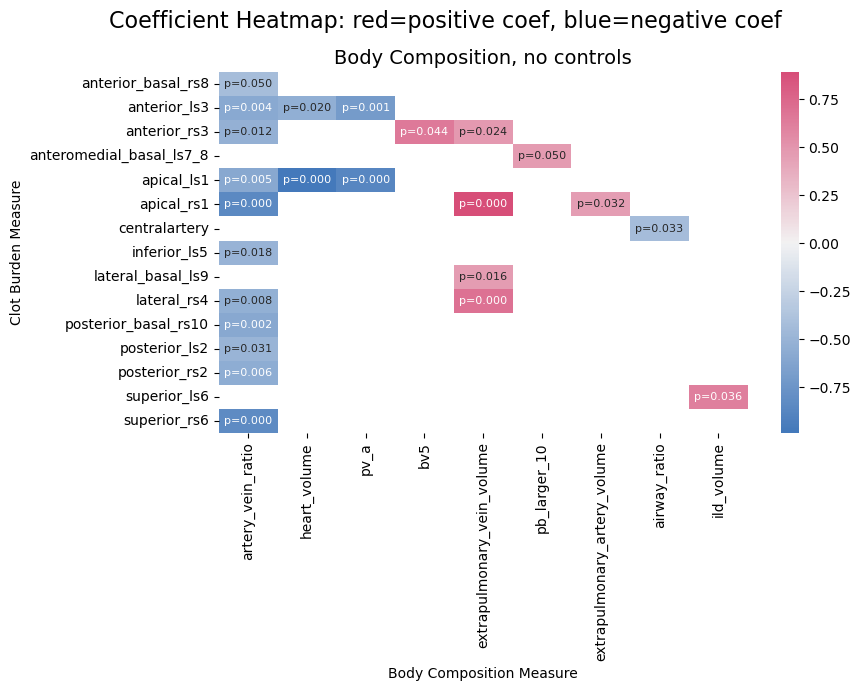

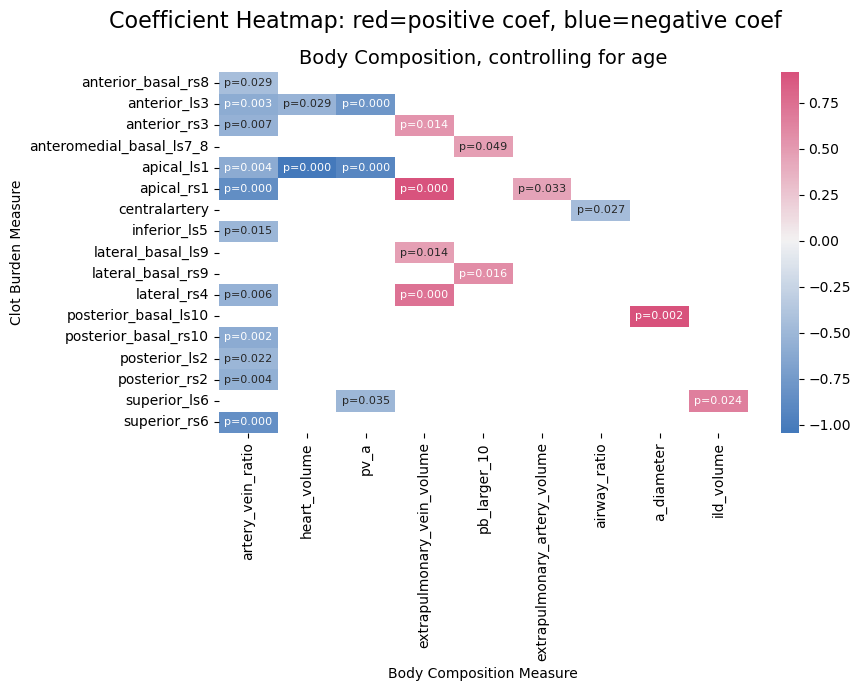

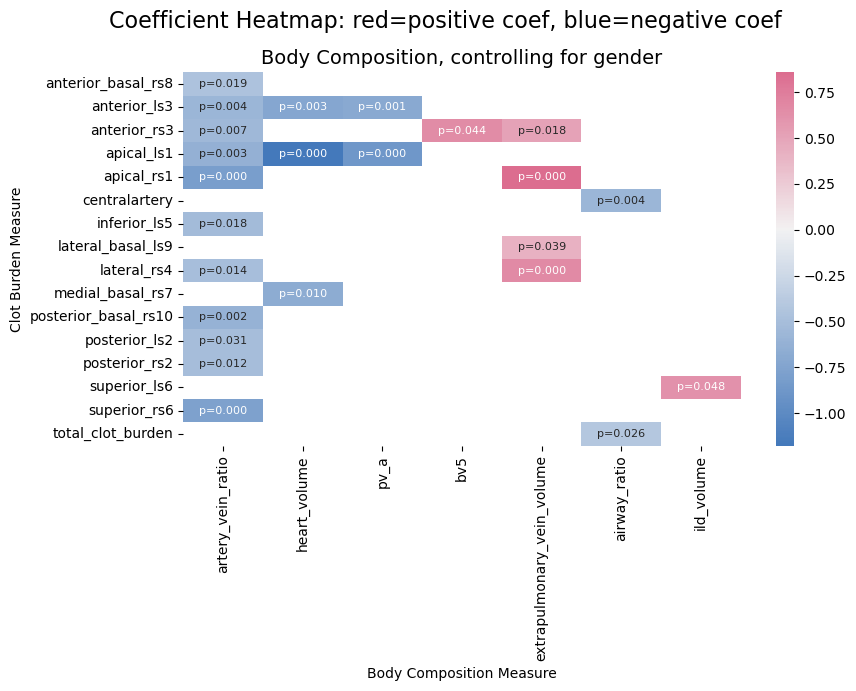

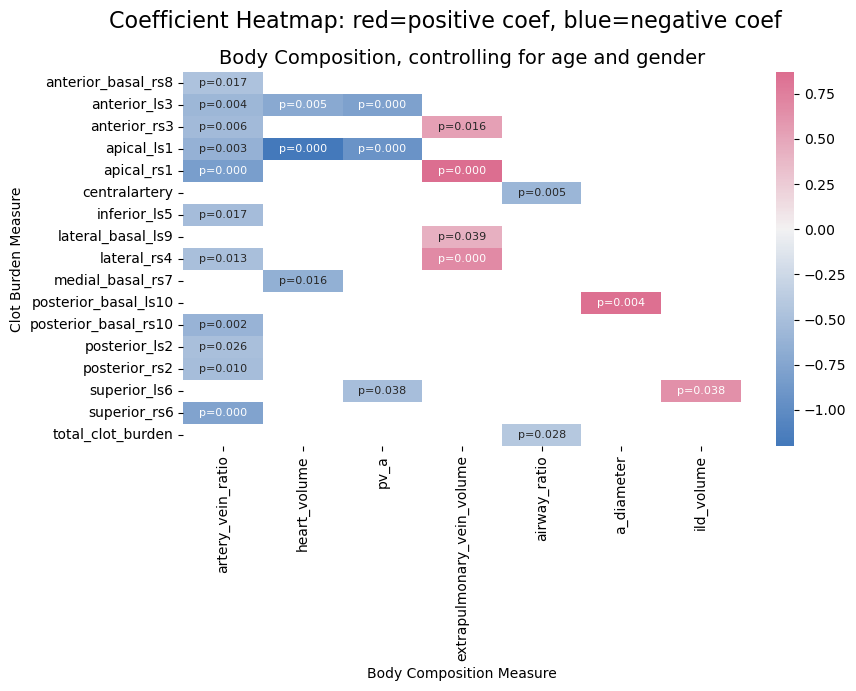

In [63]:
cardio_regression_df = pd.DataFrame()

#########################################
# OLS Body, No Controls                 #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=None
)
plot_subtitle = 'Body Composition, no controls'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[None].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)

#########################################
# OLS Body, control for age             #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['age']
)
plot_subtitle = 'Body Composition, controlling for age'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[age].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)

#########################################
# OLS Body, control for gender          #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for gender'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[gender_cl_Male].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)

#########################################
# OLS Body, control for age and gender  #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['age', 'gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for age and gender'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[age, gender].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)


### Export combined univariate regression results

In [81]:
regression_results.index.names

FrozenList(['y_var', 'x_var', 'controls'])

In [83]:
regression_results = pd.concat([body_regressions_df, cardio_regression_df], axis=0)

regression_results = regression_results.reset_index()
regression_results.index = regression_results[['y_var', 'x_var', 'controls']].apply('_'.join, axis=1)
regression_results.index.name = 'Lookup'

regression_results['variable_signif'] = regression_results['variable_pvalue'].apply(reg.add_significance)

regression_results.to_csv('../output/regressions/ols_univariate_all.csv')
regression_results.head()

,y_var,x_var,controls,const_coef,const_pvalue,const_nobs,const_r2_adj,variable_coef,variable_pvalue,variable_nobs,variable_r2_adj,age_coef,age_pvalue,age_nobs,age_r2_adj,gender_cl_Male_coef,gender_cl_Male_pvalue,gender_cl_Male_nobs,gender_cl_Male_r2_adj,variable_signif
Lookup,,,,,,,,,,,,,,,,,,,,
anterior_basal_rs8_density_bone_None,anterior_basal_rs8,density_bone,None,-2.659394,2.310575e-16,95.0,-0.010722,0.014525,0.960550,95.0,-0.010722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_density_intermuscular_fat_None,anterior_basal_rs8,density_intermuscular_fat,None,-2.651197,1.129034e-16,95.0,0.029164,-0.521351,0.199596,95.0,0.029164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_density_visceral_fat_None,anterior_basal_rs8,density_visceral_fat,None,-2.663637,2.153180e-17,95.0,0.039104,-0.581965,0.003258,95.0,0.039104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,**
anterior_basal_rs8_mass_subcutaneous_fat_None,anterior_basal_rs8,mass_subcutaneous_fat,None,-2.660840,2.748827e-16,95.0,-0.007427,0.147374,0.663681,95.0,-0.007427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_mass_visceral_fat_None,anterior_basal_rs8,mass_visceral_fat,None,-2.659742,1.890044e-16,95.0,-0.009163,-0.100320,0.706206,95.0,-0.009163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


## Multivariable Regressions

### Feature Selection

#### Recursive Feature Selection

In [65]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[cardio_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

In [66]:
rfecv_regressions = pd.DataFrame()

for target in y.columns:
	x_vars = rfecv_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip(
            ['rfecv' for _ in range(res.shape[0])],
            [target for _ in range(res.shape[0])], 
            res.index)
            ),
		names=('feature_selection_method', 'y', 'X')
	)
	rfecv_regressions = pd.concat((rfecv_regressions, res), axis=0)
	
rfecv_regressions

coef  \
feature_selection_method y                        X                             
rfecv                    total_clot_burden        const             -0.115429   
                                                  airway_ratio      -0.358527   
                         centralartery            const             -1.208445   
                                                  artery_vein_ratio -0.591892   
                                                  pb_larger_10       0.414675   
...                                                                       ...   
                         anteromedial_basal_ls7_8 pb_larger_10       0.465993   
                         lateral_basal_ls9        const             -2.825244   
                                                  artery_vein_ratio -0.487240   
                         posterior_basal_ls10     const             -2.580083   
                                                  pv_a              -0.664920   

                                                                             pval  \
feature_selection_method y                        X                                 
rfecv                    total_clot_burden        const              4.367881e-01   
                                                  airway_ratio       5.880143e-02   
                         centralartery            const              9.617352e-06   
                                                  artery_vein_ratio  2.339399e-02   
                                                  pb_larger_10       3.271859e-02   
...                                                                           ...   
                         anteromedial_basal_ls7_8 pb_larger_10       4.976054e-02   
                         lateral_basal_ls9        const              6.590702e-19   
                                                  artery_vein_ratio  1.177795e-01   
                         posterior_basal_ls10     const              6.076339e-16   
                                                  pv_a               6.574026e-02   

                                                                     nobs  \
feature_selection_method y                        X                         
rfecv                    total_clot_burden        const              95.0   
                                                  airway_ratio       95.0   
                         centralartery            const              95.0   
                                                  artery_vein_ratio  95.0   
                                                  pb_larger_10       95.0   
...                                                                   ...   
                         anteromedial_basal_ls7_8 pb_larger_10       95.0   
                         lateral_basal_ls9        const              95.0   
                                                  artery_vein_ratio  95.0   
                         posterior_basal_ls10     const              95.0   
                                                  pv_a               95.0   

                                                                    signif  
feature_selection_method y                        X                         
rfecv                    total_clot_burden        const                     
                                                  airway_ratio              
                         centralartery            const                ***  
                                                  artery_vein_ratio      *  
                                                  pb_larger_10           *  
...                                                                    ...  
                         anteromedial_basal_ls7_8 pb_larger_10           *  
                         lateral_basal_ls9        const                ***  
                                                  artery_vein_ratio         
                         posterior_basal_ls10     const         

#### Sequential Feature Selection (Backward)

In [67]:
sfs_bwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='backward',
		cv=10
	)

	sfs_fwd.fit(X[cardio_features], y[target])
	sfs_bwd_results[target] = sfs_fwd.get_feature_names_out()

In [68]:
sfs_bwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	x_vars = sfs_bwd_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip(
            ['sfs_backward' for _ in range(res.shape[0])],
            [target for _ in range(res.shape[0])], 
            res.index)
            ),
		names=('feature_selection_method', 'y', 'X')
	)
	sfs_bwd_regressions = pd.concat((sfs_bwd_regressions, res), axis=0)
	
sfs_bwd_regressions

coef  \
feature_selection_method y                    X                                        
sfs_backward             total_clot_burden    const                        -0.155247   
                                              emphysema_volume_950hu       -0.086028   
                                              extrapulmonary_artery_volume  0.025896   
                                              extrapulmonary_vein_volume    0.272936   
                                              pb_larger_10                  0.257826   
...                                                                              ...   
                         lateral_basal_ls9    extrapulmonary_vein_volume    0.643637   
                         posterior_basal_ls10 const                        -2.573240   
                                              extrapulmonary_vein_volume   -0.338487   
                                              a_diameter                    0.409832   
                                              ild_volume                    0.271161   

                                                                                    pval  \
feature_selection_method y                    X                                            
sfs_backward             total_clot_burden    const                         3.310720e-01   
                                              emphysema_volume_950hu        3.143387e-01   
                                              extrapulmonary_artery_volume  8.562074e-01   
                                              extrapulmonary_vein_volume    6.183499e-02   
                                              pb_larger_10                  1.965480e-01   
...                                                                                  ...   
                         lateral_basal_ls9    extrapulmonary_vein_volume    4.280785e-03   
                         posterior_basal_ls10 const                         1.494420e-15   
                                              extrapulmonary_vein_volume    1.470733e-01   
                                              a_diameter                    7.112901e-02   
                                              ild_volume                    2.928806e-01   

                                                                            nobs  \
feature_selection_method y                    X                                    
sfs_backward             total_clot_burden    const                         95.0   
                                              emphysema_volume_950hu        95.0   
                                              extrapulmonary_artery_volume  95.0   
                                              extrapulmonary_vein_volume    95.0   
                                              pb_larger_10                  95.0   
...                                                                          ...   
                         lateral_basal_ls9    extrapulmonary_vein_volume    95.0   
                         posterior_basal_ls10 const                         95.0   
                                              extrapulmonary_vein_volume    95.0   
                                              a_diameter                    95.0   
                                              ild_volume                    95.0   

                                                                           signif  
feature_selection_method y                    X                                    
sfs_backward             total_clot_burden    const                                
                                              emphysema_volume_950hu               
                                              extrapulmonary_artery_volume         
                                              extrapulmonary_vein_volume           
                                              pb_larger_10                         
...                                                      

#### Sequential Feature Selection (Forward)

In [69]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[cardio_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

In [70]:
sfs_fwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	x_vars = sfs_fwd_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip(
            ['sfs_forward' for _ in range(res.shape[0])],
            [target for _ in range(res.shape[0])], 
            res.index)
            ),
		names=('feature_selection_method', 'y', 'X')
	)
	sfs_fwd_regressions = pd.concat((sfs_fwd_regressions, res), axis=0)
	
sfs_fwd_regressions

coef  \
feature_selection_method y                    X                                      
sfs_forward              total_clot_burden    const                      -0.120006   
                                              extrapulmonary_vein_volume  0.230933   
                                              pb_larger_10                0.190038   
                                              pv_a                       -0.249812   
                                              airway_ratio               -0.351326   
...                                                                            ...   
                         lateral_basal_ls9    const                      -2.968629   
                                              emphysema_volume_950hu     -0.319949   
                                              extrapulmonary_vein_volume  0.643637   
                         posterior_basal_ls10 const                      -2.580083   
                                              pv_a                       -0.664920   

                                                                                  pval  \
feature_selection_method y                    X                                          
sfs_forward              total_clot_burden    const                       4.130335e-01   
                                              extrapulmonary_vein_volume  3.329944e-02   
                                              pb_larger_10                1.520129e-01   
                                              pv_a                        1.139506e-02   
                                              airway_ratio                4.762356e-02   
...                                                                                ...   
                         lateral_basal_ls9    const                       7.529403e-21   
                                              emphysema_volume_950hu      9.264112e-02   
                                              extrapulmonary_vein_volume  4.280785e-03   
                         posterior_basal_ls10 const                       6.076339e-16   
                                              pv_a                        6.574026e-02   

                                                                          nobs  \
feature_selection_method y                    X                                  
sfs_forward              total_clot_burden    const                       95.0   
                                              extrapulmonary_vein_volume  95.0   
                                              pb_larger_10                95.0   
                                              pv_a                        95.0   
                                              airway_ratio                95.0   
...                                                                        ...   
                         lateral_basal_ls9    const                       95.0   
                                              emphysema_volume_950hu      95.0   
                                              extrapulmonary_vein_volume  95.0   
                         posterior_basal_ls10 const                       95.0   
                                              pv_a                        95.0   

                                                                         signif  
feature_selection_method y                    X                                  
sfs_forward              total_clot_burden    const                              
                                              extrapulmonary_vein_volume      *  
                                              pb_larger_10                       
                                              pv_a                            *  
                                              airway_ratio                    *  
...                                                                         ...  
                         lateral_basal_ls9    const              

#### Combine feature selection results

In [71]:
feat_selection_cardio = pd.concat([rfecv_regressions, sfs_fwd_regressions, sfs_bwd_regressions], axis=0)

In [76]:
feat_selection_all.reset_index().columns

Index(['feature_selection_method', 'y', 'X', 'coef', 'pval', 'nobs', 'signif'], dtype='object')

In [80]:
feat_selection_all = pd.concat([feat_selection_body, feat_selection_cardio], axis=0)
feat_selection_all = feat_selection_all.reset_index()
feat_selection_all.index = feat_selection_all[['feature_selection_method', 'y', 'X']].apply('_'.join, axis=1)
feat_selection_all.index.name = 'Lookup'
feat_selection_all.to_csv('../output/regressions/ols_multivariable_all.csv')
feat_selection_all.head()

,feature_selection_method,y,X,coef,pval,nobs,signif
Lookup,,,,,,,
rfecv_total_clot_burden_const,rfecv,total_clot_burden,const,-0.115706,0.421797,95.0,
rfecv_total_clot_burden_density_bone,rfecv,total_clot_burden,density_bone,0.459730,0.011830,95.0,*
rfecv_centralartery_const,rfecv,centralartery,const,-1.196293,0.000020,95.0,***
rfecv_centralartery_volume_intermuscular_fat,rfecv,centralartery,volume_intermuscular_fat,0.345211,0.120491,95.0,
rfecv_centralartery_density_bone,rfecv,centralartery,density_bone,0.485214,0.023332,95.0,*
